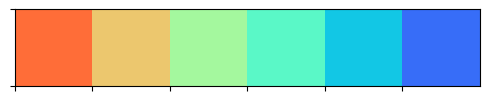

In [1]:
import os, warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import tensorflow as tf
import gc
import tensorflow.keras.backend as K

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import pandas as pd
from pandas import Series
import numpy as np
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import molmap.model

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette("rainbow_r", 6) #PiYG
sns.palplot(color)

from joblib import load, dump
import sklearn.metrics
import scipy
import logging

def r2_score(y_true,y_pred):
    y_mean = np.mean(y_true)
    r2 = 1-sum((y_true-y_pred)**2)/sum((y_mean-y_true)**2)
    return r2
def PCC(y_pred,y_true):
    diff_pred,diff_true=y_pred-np.mean(y_pred),y_true-np.mean(y_true)
    return np.sum(diff_pred*diff_true)/np.sqrt(np.sum(diff_pred**2)*np.sum(diff_true**2))

def from_ic50(ic50, max_ic50=50000.0):
    x = 1.0 - (np.log(np.maximum(ic50, 1e-12)) / np.log(max_ic50))
    return np.minimum(
        1.0,
        np.maximum(0.0, x))
def to_ic50(x, max_ic50=50000.0):
    return max_ic50 ** (1.0 - x)
sample_weight=None,
threshold_nm=500,
max_ic50=50000

读取 blosum62 matrix + pam250 matrix

In [2]:
blosum62 = pd.read_csv('/mnt/zt/Dopaap/dopaap_predictor/blosum_pam_data/BLOSUM62.txt', sep='\s')
blosum62 = blosum62.iloc[:-4,:-4]

pam250 = pd.read_csv('/mnt/zt/Dopaap/dopaap_predictor/blosum_pam_data/PAM250.csv',index_col=0)

将 blosum62 matrix 以及 pam250 mutation matrix 标准化到 0~1

In [3]:
# aapro归一化
PCP = pd.read_csv('/mnt/zt/Dopaap/dopaap_predictor/cal_CTD/PCP_61.csv', index_col='properties').index
AApro_dic = pd.read_csv('/mnt/zt/Dopaap/dopaap_predictor/umap/single_index/AApro_UMAP.csv', header=0,index_col=0)
AA_pro = AApro_dic.loc[PCP].astype('float')
AA_pro = AA_pro.T
AA_pro = ((AA_pro - AA_pro.min()) / (AA_pro.max() - AA_pro.min())).T #归一化

序列相关 aapro,blosum62,pam250 距离矩阵的生成与拼接

In [4]:
def get_3d_feat(seq):
    n = len(seq)

    # 生成理化性质矩阵
    seq_pro = pd.DataFrame(AA_pro[aa] for aa in seq).T
    seq_pro = seq_pro.values[:, :, None]  #二维变成三维（61， n， 1）
    ## 相乘
    mt_pro = np.transpose((seq_pro * np.transpose(seq_pro, [0, 2, 1])), [1, 2, 0])  #**.5   #here!! **0.25
    ## transpose三维转置。（61，n，1）*（61，1，n）=（61，n，n），再转置成（n，n，61）.

    # 生成blosum矩阵
    seq_blosum = np.ones((n,n))
    for i in range(n):
        a = seq[i]
        for j in range(n):
            b = seq[j]
            seq_blosum[i][j] = blosum62.loc[a,b]
    seq_blosum_nor = ((seq_blosum - seq_blosum.min()) / (seq_blosum.max() - seq_blosum.min()))
    seq_blosum_nor = seq_blosum_nor[:, :, np.newaxis]  ##（n，n，1）

    # 生成pam矩阵
    seq_pam = np.ones((n,n))
    for i in range(n):
        a = seq[i]
        for j in range(n):
            b = seq[j]
            seq_pam[i][j] = pam250.loc[a,b]
    seq_pam_nor = ((seq_pam - seq_pam.min()) / (seq_pam.max() - seq_pam.min()))
    seq_pam_nor = seq_pam_nor[:, :, np.newaxis]  ##（n，n，1）

    # 生成序列距离矩阵
    pt_dis = np.ones((n,n))
    for i in range(n):
        for j in range(n):
            pt_dis[i][j] = abs(i-j)
    pt_dis = ((pt_dis - 0) / (n-1 - 0)) ## 归一化（最小值为0，最大值为n-1）
    pt_dis = pt_dis[:, :, np.newaxis]  ##（n，n，1）

    # 改变 理化性质矩阵 的下半部分
    for k in range(mt_pro.shape[2]):
        for i in range(n):
            for j in range(i):
                if k < 60:                                      ##here
                    mt_pro[i,j,k] = (mt_pro[j,i,k] * mt_pro[j,i,k+1])**.5
                else:
                    mt_pro[i,j,k] = (mt_pro[j,i,k] * mt_pro[j,i,0])**.5

    # 将序列距离矩阵与mt合并，并放在第一层
    mt = np.concatenate((pt_dis,seq_blosum_nor,seq_pam_nor,mt_pro),axis = 2)

    x = np.pad(mt, [(0, max_seq_len-n), (0, max_seq_len-n), (0, 0)]) #填充0.令数据集中每条序列对应的Xshape相同。

    return x[ :, :, :, None]

在HLA-I测试

In [16]:
Test_dir = '/mnt/zt/Dopaap/calculate_webtools_score/HLA-I_dataset/web_tools_prediction_group_by_allele'
tf_model_dir = '/mnt/zt/Dopaap/dopaap_predictor/train_before_2016_no_ms_new_super_params/tf_model'

for file in os.listdir(Test_dir):
    allele = file.split('.')[0]
    if allele not in os.listdir(tf_model_dir):
        print(f'{allele} is not supportable')
        continue
    
    df_test = pd.read_csv(os.path.join(Test_dir,file))  
    
    print(f'*************{allele} predict start**************')
    
    # 创建储存 allele 结果的文件夹
    test_result_dir = '/mnt/zt/Dopaap/calculate_webtools_score/HLA-I_dataset/Dopaap_result/group_by_allele'
    allele_fold = os.path.join(test_result_dir, allele)

    if not os.path.exists(allele_fold) : 
        os.makedirs(allele_fold)
    max_seq_len = 15
   
   # 生成 X_test + Y_test 
    X_test_name = os.path.join(allele_fold, allele+'_X_test_'+'.data')
    if not os.path.exists(X_test_name) :
        X_test = []
        for seq in df_test['peptide']:
            X_test.append(get_3d_feat(seq))
        X_test = np.stack(X_test)
        dump(X_test, X_test_name)
    else:
        X_test = load(X_test_name)
    X_test = X_test.astype('float32')
    Y_test = df_test['Normalized_QM'].values.reshape(-1, 1) 

    
    model = tf.keras.models.load_model(f'{tf_model_dir}/{allele}')
    # make prediction
    Y_test_pred = model.predict(X_test)
    df_pred = pd.DataFrame(Y_test_pred.tolist()).rename(columns={0:'Pred_Norm_QM'})
    df_pred['Pred_QM'] = df_pred['Pred_Norm_QM'].apply(to_ic50)
    df_true_pred = pd.merge(df_test,df_pred,how='inner',left_index=True,right_index=True)   

    y_true = df_true_pred['Normalized_QM']
    y_pred = df_true_pred['Pred_Norm_QM']
    df_true_pred = df_true_pred.iloc[:, 1:]
    df_true_pred.to_csv(os.path.join(test_result_dir, allele, 'predict_result.csv'), index=False)
    
    # 删除model
    del model
 
    print(f'*************{allele} predict finished**************')

*************HLA-A_0101 predict start**************
2/2 [==============================] - 0s 5ms/step
*************HLA-A_0101 predict finished**************
*************HLA-A_0201 predict start**************
14/14 [==============================] - 0s 9ms/step
*************HLA-A_0201 predict finished**************
*************HLA-A_0202 predict start**************
5/5 [==============================] - 0s 9ms/step
*************HLA-A_0202 predict finished**************
*************HLA-A_0203 predict start**************
4/4 [==============================] - 0s 15ms/step
*************HLA-A_0203 predict finished**************
*************HLA-A_0205 predict start**************
1/1 [==============================] - 0s 149ms/step
*************HLA-A_0205 predict finished**************
*************HLA-A_0206 predict start**************
3/3 [==============================] - 0s 7ms/step
*************HLA-A_0206 predict finished**************
*************HLA-A_0301 predict start**********

在HPV16测试集测试

In [5]:
Test_dir = '/mnt/zt/Dopaap/calculate_webtools_score/compare_HPV16_dataset/hpv16_benchmark_groupby_allele'
tf_model_dir = '/mnt/zt/Dopaap/dopaap_predictor/train_before_2016_no_ms_new_super_params/tf_model'

for file in os.listdir(Test_dir):
    allele = file.split('.')[0]
    if allele not in os.listdir(tf_model_dir):
        print(f'{allele} is not supportable')
        continue
    
    df_test = pd.read_csv(os.path.join(Test_dir,file))  
    
    print(f'*************{allele} predict start**************')
    
    # 创建储存 allele 结果的文件夹
    test_result_dir = '/mnt/zt/Dopaap/calculate_webtools_score/compare_HPV16_dataset/Dopaap_result/group_by_allele'
    allele_fold = os.path.join(test_result_dir, allele)

    if not os.path.exists(allele_fold) : 
        os.makedirs(allele_fold)
    max_seq_len = 15
   
   # 生成 X_test + Y_test 
    X_test_name = os.path.join(allele_fold, allele+'_X_test_'+'.data')
    if not os.path.exists(X_test_name) :
        X_test = []
        for seq in df_test['peptide']:
            X_test.append(get_3d_feat(seq))
        X_test = np.stack(X_test)
        dump(X_test, X_test_name)
    else:
        X_test = load(X_test_name)
    X_test = X_test.astype('float32')
    Y_test = df_test['Normalized_QM'].values.reshape(-1, 1) 

    
    model = tf.keras.models.load_model(f'{tf_model_dir}/{allele}')
    # make prediction
    Y_test_pred = model.predict(X_test)
    df_pred = pd.DataFrame(Y_test_pred.tolist()).rename(columns={0:'Pred_Norm_QM'})
    df_pred['Pred_QM'] = df_pred['Pred_Norm_QM'].apply(to_ic50)
    df_true_pred = pd.merge(df_test,df_pred,how='inner',left_index=True,right_index=True)   

    y_true = df_true_pred['Normalized_QM']
    y_pred = df_true_pred['Pred_Norm_QM']
    df_true_pred = df_true_pred.iloc[:, 1:]
    df_true_pred.to_csv(os.path.join(test_result_dir, allele, 'predict_result.csv'), index=False)
    
    # 删除model
    del model
 
    print(f'*************{allele} predict finished**************')

*************HLA-A_0101 predict start**************
1/1 [==============================] - 3s 3s/step
*************HLA-A_0101 predict finished**************
*************HLA-A_0201 predict start**************
4/4 [==============================] - 0s 14ms/step
*************HLA-A_0201 predict finished**************
*************HLA-A_0301 predict start**************
3/3 [==============================] - 0s 16ms/step
*************HLA-A_0301 predict finished**************
*************HLA-A_1101 predict start**************
4/4 [==============================] - 0s 14ms/step
*************HLA-A_1101 predict finished**************
*************HLA-A_2402 predict start**************
3/3 [==============================] - 0s 47ms/step
*************HLA-A_2402 predict finished**************
*************HLA-B_0702 predict start**************
1/1 [==============================] - 0s 212ms/step
*************HLA-B_0702 predict finished**************
*************HLA-B_1501 predict start**********

在新数据测试

In [25]:
Test_dir = '/mnt/zt/Dopaap/calculate_webtools_score/new_released/iedb_tools_predict_data_processed'
tf_model_dir = '/mnt/zt/Dopaap/dopaap_predictor/train_before_2016_no_ms_new_super_params/tf_model'

for allele in os.listdir(Test_dir):
    if allele not in os.listdir(tf_model_dir):
        print(f'{allele} is not supportable')
        continue
    
    df_test = pd.read_csv(os.path.join(Test_dir, allele, 'tools_processed.csv'))  
    
    print(f'*************{allele} predict start**************')
    
    # 创建储存 allele 结果的文件夹
    test_result_dir = '/mnt/zt/Dopaap/calculate_webtools_score/new_released/dopaap_new_super_param_pred_result_after2021'
    allele_fold = os.path.join(test_result_dir, allele)

    if not os.path.exists(allele_fold) : 
        os.makedirs(allele_fold)
    max_seq_len = 15
   
   # 生成 X_test + Y_test 
    X_test_name = os.path.join(allele_fold, allele+'_X_test_'+'.data')
    if not os.path.exists(X_test_name) :
        X_test = []
        for seq in df_test['Description']:
            X_test.append(get_3d_feat(seq))
        X_test = np.stack(X_test)
        dump(X_test, X_test_name)
    else:
        X_test = load(X_test_name)
    X_test = X_test.astype('float32')
    Y_test = df_test['Normalized_QM'].values.reshape(-1, 1) 

    
    model = tf.keras.models.load_model(f'{tf_model_dir}/{allele}')
    # make prediction
    Y_test_pred = model.predict(X_test)
    df_pred = pd.DataFrame(Y_test_pred.tolist()).rename(columns={0:'Pred_Norm_QM'})
    df_pred['Pred_QM'] = df_pred['Pred_Norm_QM'].apply(to_ic50)
    df_test['Dopaap-new-super-params_IC50_Normalized'] = df_pred['Pred_Norm_QM']
    df_test.to_csv(os.path.join(Test_dir, allele, 'tools_processed.csv'), index=False)
    
    # 删除model
    del model
 
    print(f'*************{allele} predict finished**************')
    

    




*************HLA-A_0201 predict start**************
6/6 [==============================] - 0s 9ms/step
*************HLA-A_0201 predict finished**************
*************HLA-A_0301 predict start**************
4/4 [==============================] - 0s 7ms/step
*************HLA-A_0301 predict finished**************
*************HLA-A_0101 predict start**************
2/2 [==============================] - 0s 7ms/step
*************HLA-A_0101 predict finished**************
*************HLA-A_1101 predict start**************
2/2 [==============================] - 0s 6ms/step
*************HLA-A_1101 predict finished**************
HLA-A_3303 is not supportable
*************HLA-A_2402 predict start**************
3/3 [==============================] - 0s 10ms/step
*************HLA-A_2402 predict finished**************
*************HLA-B_0702 predict start**************
2/2 [==============================] - 0s 8ms/step
*************HLA-B_0702 predict finished**************
*************HLA-B_15

In [36]:
alldata_res = {}

res_files = '/mnt/hly2020/Dopaap-zt/retrain-find-sota-on-plos/Res'
for allele in os.listdir(res_files):
    # print(allele)
    res_file = pd.read_csv(os.path.join(res_files,allele) + '/results/' + allele +'_noMS_results.csv',index_col=0)
    alldata_res[allele] = res_file.iloc[0]
    df_alldata_res = pd.DataFrame(alldata_res).T

df_alldata_res.to_csv('/mnt/hly2020/Dopaap-zt/retrain-find-sota-on-plos/pred_true/results_noMS_1.csv')

In [17]:
# 拼接HLA-I测试集的预测结果
test_result_top_dir = '/mnt/zt/Dopaap/calculate_webtools_score/HLA-I_dataset/Dopaap_result'
df_all_pred = pd.DataFrame()
for allele in os.listdir(test_result_dir):
    pred_file = pd.read_csv(f'{test_result_dir}/{allele}/predict_result.csv')
    pred_file['allele'] = allele 
    df_all_pred = df_all_pred.append(pred_file)
df_all_pred.to_csv(f'{test_result_top_dir}/all_predict_result.csv', index=False)

In [6]:
# 拼接HPV16测试集的预测结果
test_result_top_dir = '/mnt/zt/Dopaap/calculate_webtools_score/compare_HPV16_dataset/Dopaap_result'
df_all_pred = pd.DataFrame()
for allele in os.listdir(test_result_dir):
    pred_file = pd.read_csv(f'{test_result_dir}/{allele}/predict_result.csv')
    pred_file['allele'] = allele 
    df_all_pred = df_all_pred.append(pred_file)
df_all_pred.to_csv(f'{test_result_top_dir}/all_predict_result.csv', index=False)

In [12]:
# 拼接读取模型进行预测plos结果
res_files = '/mnt/hly2020/Dopaap-zt/retrain-find-sota-on-plos/test_dir/pred_true_result'
df_allpred = pd.DataFrame()
for file in os.listdir(res_files):
    pred_file = pd.read_csv(os.path.join(res_files, file), index_col=0)
    df_allpred = df_allpred.append(pred_file)
df_allpred.to_csv('/mnt/hly2020/Dopaap-zt/retrain-find-sota-on-plos/test_dir/predresults_noMS.csv',index=0)

In [35]:
# 拼接新测试集的预测结果
res_files = '/mnt/hly2020/Dopaap-zt/retrain-find-sota-on-plos/2021_MHC_I/Dopaap_pred/pred_true_result'
df_allpred = pd.DataFrame()
for file in os.listdir(res_files):
    pred_file = pd.read_csv(os.path.join(res_files, file), index_col=0)
    df_allpred = df_allpred.append(pred_file)
df_allpred.to_csv('/mnt/hly2020/Dopaap-zt/retrain-find-sota-on-plos/2021_MHC_I/Dopaap_pred/predresults_new_1.csv',index=0)